## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Metadata

In [3]:
# Load metadata to understand the dataset structure
with open('../data/synthetic_migraine_meta.json', 'r') as f:
    meta = json.load(f)

print("Dataset Configuration:")
print(json.dumps(meta['config'], indent=2))
print("\nDataset Statistics:")
print(json.dumps(meta['dataset_stats'], indent=2))
print("\nFeatures:")
for i, feat in enumerate(meta['features'], 1):
    print(f"{i:2d}. {feat}")

Dataset Configuration:
{
  "n_users": 10000,
  "horizon": 365,
  "train_split": 0.8,
  "random_seed": 42,
  "latent_dim": 4,
  "baseline_migraine_rate": 0.15
}

Dataset Statistics:
{
  "train": {
    "n_records": 2920000,
    "n_users": 8000,
    "migraine_rate": 0.14584178082191782,
    "avg_migraines_per_user": 53.23225
  },
  "val": {
    "n_records": 730000,
    "n_users": 2000,
    "migraine_rate": 0.1452041095890411,
    "avg_migraines_per_user": 52.9995
  }
}

Features:
 1. Sleep Duration (hours)
 2. Sleep Quality (1-10)
 3. Sleep Consistency Score
 4. Stress Level (1-10)
 5. Work Hours
 6. Anxiety Score (1-10)
 7. Caffeine Intake (mg)
 8. Water Intake (L)
 9. Meal Regularity (1-10)
10. Exercise Duration (min)
11. Physical Activity Level (1-10)
12. Neck Tension (1-10)
13. Screen Time (hours)
14. Weather Pressure (hPa)
15. Noise Level (dB)
16. Hormone Fluctuation Index
17. Menstrual Cycle Day
18. Alcohol Consumption (units)
19. Smoking (cigarettes/day)
20. Meditation Time (min)


## 3. Load Training and Validation Data

In [6]:
# Load training data
print("Loading training data...")
train_df = pd.read_csv('../data/synthetic_migraine_train.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Training data migraine rate: {train_df['migraine'].mean():.4f}")

# Load validation data
print("\nLoading validation data...")
val_df = pd.read_csv('../data/synthetic_migraine_val.csv')
print(f"Validation data shape: {val_df.shape}")
print(f"Validation data migraine rate: {val_df['migraine'].mean():.4f}")

# Display first few rows
print("\nFirst few rows of training data:")
train_df.head()

Loading training data...
Training data shape: (2920000, 28)
Training data migraine rate: 0.1458

Loading validation data...
Validation data shape: (730000, 28)
Validation data migraine rate: 0.1452

First few rows of training data:


,user_id,day,Z_stress,Z_sleepDebt,Z_hormonal,Z_envLoad,migraine_prob,migraine,Sleep Duration (hours),Sleep Quality (1-10),...,Physical Activity Level (1-10),Neck Tension (1-10),Screen Time (hours),Weather Pressure (hPa),Noise Level (dB),Hormone Fluctuation Index,Menstrual Cycle Day,Alcohol Consumption (units),Smoking (cigarettes/day),Meditation Time (min)
0,0,0,0.113365,0.044292,-0.001441,0.067272,0.154112,0,6.719016,6.078553,...,2.050164,3.094281,4.961507,1017.713710,44.103711,1.469241,13.313890,0.935637,8.138295,157.509856
1,0,1,-0.094988,0.080566,0.057002,0.123731,0.148513,0,8.136928,5.416928,...,5.893722,6.346166,8.514105,1011.265276,51.386756,1.303695,23.375913,0.862552,0.440424,5.050103
2,0,2,-0.026288,-0.095946,0.205424,0.191983,0.155528,0,5.992939,5.943418,...,5.355980,7.008832,9.084908,1003.323204,59.336747,8.845091,21.816114,34.297300,0.834781,8.177297
3,0,3,-0.072755,-0.063101,0.198359,0.121278,0.150599,0,7.022800,9.160209,...,7.437290,2.744867,7.017014,1007.118378,37.437821,5.740301,1.187708,2.085377,0.061867,17.210470
4,0,4,-0.044948,-0.060940,0.243741,0.245375,0.160935,0,9.263423,6.814240,...,5.430576,1.578305,11.428468,1024.278995,64.492383,2.726531,10.930145,5.839731,26.802325,5.049853


## 4. Prepare Features and Target

In [ ]:
# Define feature columns (all columns except user_id, day, migraine, and latent states)
exclude_cols = ['user_id', 'day', 'migraine', 'migraine_prob']

# Also exclude latent state columns if they exist
latent_cols = [col for col in train_df.columns if col.startswith('Z_')]
exclude_cols.extend(latent_cols)

# Get feature columns
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Separate features and target
X_train = train_df[feature_cols]
y_train = train_df['migraine']

X_val = val_df[feature_cols]
y_val = val_df['migraine']

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

Number of features: 24

Feature columns:
 1. user_id
 2. day
 3. migraine_prob
 4. migraine
 5. Sleep Duration (hours)
 6. Sleep Quality (1-10)
 7. Sleep Consistency Score
 8. Stress Level (1-10)
 9. Work Hours
10. Anxiety Score (1-10)
11. Caffeine Intake (mg)
12. Water Intake (L)
13. Meal Regularity (1-10)
14. Exercise Duration (min)
15. Physical Activity Level (1-10)
16. Neck Tension (1-10)
17. Screen Time (hours)
18. Weather Pressure (hPa)
19. Noise Level (dB)
20. Hormone Fluctuation Index
21. Menstrual Cycle Day
22. Alcohol Consumption (units)
23. Smoking (cigarettes/day)
24. Meditation Time (min)

X_train shape: (2920000, 24)
X_val shape: (730000, 24)

X_train shape: (2920000, 24)
X_val shape: (730000, 24)


## 5. Feature Scaling

Standardize features for better logistic regression performance.

In [9]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled successfully")
print(f"Mean of scaled training features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled training features: {X_train_scaled.std():.6f}")

Features scaled successfully
Mean of scaled training features: 0.000000
Std of scaled training features: 1.000000
Std of scaled training features: 1.000000


## 6. Train Logistic Regression Model

In [10]:
# Train logistic regression
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

lr_model.fit(X_train_scaled, y_train)
print("\nModel trained successfully!")

Training Logistic Regression model...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.



Model trained successfully!


## 7. Make Predictions

In [11]:
# Predictions on training set
y_train_pred = lr_model.predict(X_train_scaled)
y_train_pred_proba = lr_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on validation set
y_val_pred = lr_model.predict(X_val_scaled)
y_val_pred_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

print("Predictions completed")

Predictions completed


## 8. Evaluate Model Performance

In [12]:
# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred_proba)

# Validation set metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_pred_proba)

# Print metrics
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\n{'Metric':<20} {'Training':>15} {'Validation':>15}")
print("-" * 60)
print(f"{'Accuracy':<20} {train_accuracy:>15.4f} {val_accuracy:>15.4f}")
print(f"{'Precision':<20} {train_precision:>15.4f} {val_precision:>15.4f}")
print(f"{'Recall':<20} {train_recall:>15.4f} {val_recall:>15.4f}")
print(f"{'F1-Score':<20} {train_f1:>15.4f} {val_f1:>15.4f}")
print(f"{'ROC-AUC':<20} {train_auc:>15.4f} {val_auc:>15.4f}")
print("=" * 60)

MODEL PERFORMANCE METRICS

Metric                      Training      Validation
------------------------------------------------------------
Accuracy                      1.0000          1.0000
Precision                     1.0000          1.0000
Recall                        1.0000          1.0000
F1-Score                      1.0000          1.0000
ROC-AUC                       1.0000          1.0000


## 9. Confusion Matrix

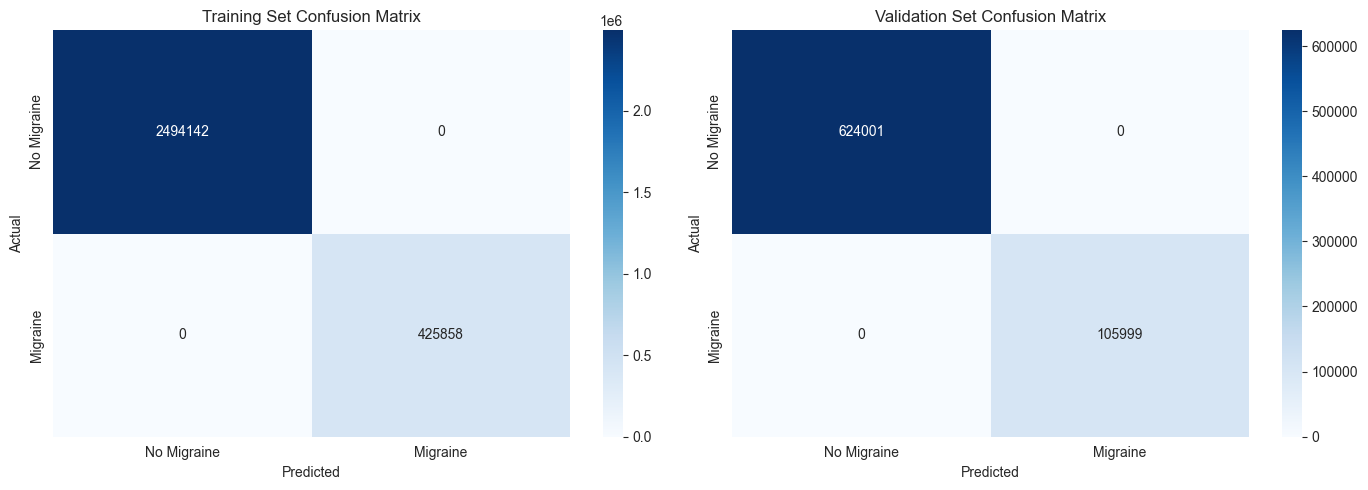

In [13]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Migraine', 'Migraine'])
axes[0].set_yticklabels(['No Migraine', 'Migraine'])

# Validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Migraine', 'Migraine'])
axes[1].set_yticklabels(['No Migraine', 'Migraine'])

plt.tight_layout()
plt.show()

## 10. ROC Curves

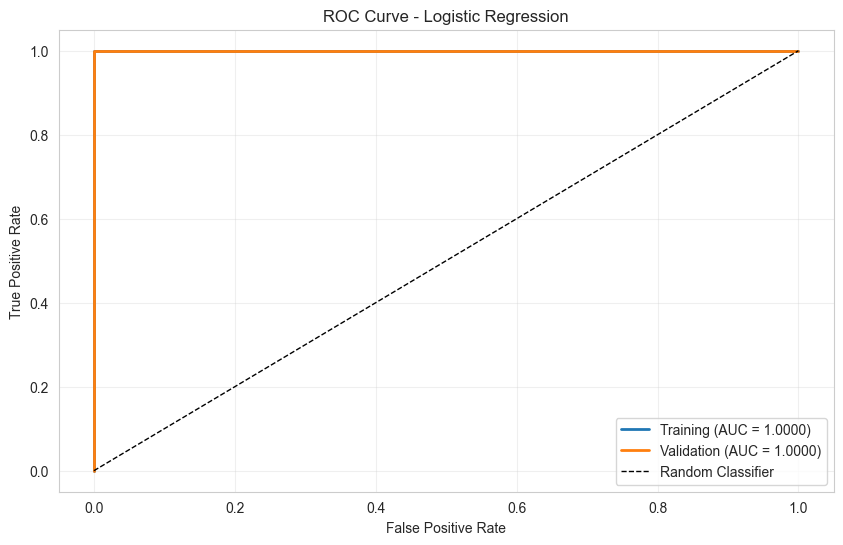

In [14]:
# Compute ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {train_auc:.4f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 11. Feature Importance Analysis

In [15]:
# Get feature coefficients
coefficients = lr_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print("=" * 70)
print(f"{'Rank':<6} {'Feature':<40} {'Coefficient':>12}")
print("-" * 70)
for idx, (i, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"{idx:<6} {row['Feature']:<40} {row['Coefficient']:>12.6f}")
print("=" * 70)


Top 15 Most Important Features:
Rank   Feature                                   Coefficient
----------------------------------------------------------------------
1      migraine                                     6.497048
2      migraine_prob                                0.027800
3      Caffeine Intake (mg)                        -0.000723
4      Water Intake (L)                            -0.000709
5      Sleep Duration (hours)                      -0.000684
6      Smoking (cigarettes/day)                    -0.000679
7      Neck Tension (1-10)                         -0.000679
8      Anxiety Score (1-10)                        -0.000655
9      Alcohol Consumption (units)                 -0.000613
10     Hormone Fluctuation Index                   -0.000559
11     Sleep Consistency Score                     -0.000530
12     Meal Regularity (1-10)                      -0.000527
13     Work Hours                                  -0.000468
14     Sleep Quality (1-10)               

## 12. Visualize Feature Coefficients

In [ ]:
# Plot top 20 features by absolute coefficient
top_features = feature_importance.head(20)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features by Coefficient (Green: Positive, Red: Negative)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 13. Predicted Probability Distribution

In [ ]:
# Plot distribution of predicted probabilities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].hist(y_train_pred_proba[y_train == 0], bins=50, alpha=0.6, label='No Migraine', color='blue')
axes[0].hist(y_train_pred_proba[y_train == 1], bins=50, alpha=0.6, label='Migraine', color='red')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Set - Predicted Probability Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].hist(y_val_pred_proba[y_val == 0], bins=50, alpha=0.6, label='No Migraine', color='blue')
axes[1].hist(y_val_pred_proba[y_val == 1], bins=50, alpha=0.6, label='Migraine', color='red')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Validation Set - Predicted Probability Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Classification Report

In [ ]:
print("Training Set Classification Report:")
print("=" * 60)
print(classification_report(y_train, y_train_pred, target_names=['No Migraine', 'Migraine']))

print("\nValidation Set Classification Report:")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=['No Migraine', 'Migraine']))

## 15. Summary and Conclusions

In [ ]:
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"\nModel: Logistic Regression")
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nValidation Performance:")
print(f"  - Accuracy:  {val_accuracy:.4f}")
print(f"  - Precision: {val_precision:.4f}")
print(f"  - Recall:    {val_recall:.4f}")
print(f"  - F1-Score:  {val_f1:.4f}")
print(f"  - ROC-AUC:   {val_auc:.4f}")
print(f"\nTop 3 Most Important Features (by absolute coefficient):")
for idx, (i, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"  {idx}. {row['Feature']} (coef: {row['Coefficient']:.6f})")
print("=" * 70)